## Efficient V1

<img src="resources/efficientnetv1_perf.png" alt="drawing" width="60%"/>

无论是提高网络深度,增加网络宽度和提高输入图像的分辨率都可以提升网络的容量从而提升网络的精度. EfficientNet V1提出了可以联合调整深度,宽度和输入图像的分辨率,使得在固定的计算开销和访存开销下求得最优网络配置

<img src="resources/efficientnet_v1_formula.png" alt="drawing" width="40%"/>


In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory

train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=None,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=None,
)

In [3]:
from venv import create
from hdd.data_util.auto_augmentation import ImageNetPolicy

from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader
from hdd.models.cnn.efficientnet import create_efficient_net
from hdd.train.classification_utils import (
    naive_train_classification_model,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    net,
    train_dataloader,
    val_dataloader,
    lr=1e-3,
    weight_decay=1e-3,
    max_epochs=100,
) -> dict[str, list[float]]:
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return training_stats


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader


# 我们提前计算好了训练数据集上的均值和方差
TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]

stats = {}
net_names = ["efficientnet_b0", "efficientnet_b3", "efficientnet_b5"]
batch_sizes = [64, 32, 8]
for net_name, batch_size in zip(net_names, batch_sizes):
    net, resize_size, crop_size = create_efficient_net(net_name, 0.1, 10)
    net = net.to(DEVICE)
    train_dataset_transforms = transforms.Compose(
        [
            transforms.Resize(resize_size),
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            ImageNetPolicy(),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    train_dataset.transform = train_dataset_transforms
    val_dataset_transforms = transforms.Compose(
        [
            transforms.Resize(resize_size),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    val_dataset.transform = val_dataset_transforms
    train_dataloader, val_dataloader = build_dataloader(
        batch_size, train_dataset, val_dataset
    )
    print(f"-----------------------{net_name}------------------------")
    max_epochs = 100
    stats[net_name] = train_net(
        net,
        train_dataloader,
        val_dataloader,
        lr=0.001,
        weight_decay=0,
        max_epochs=max_epochs,
    )
    del net

-----------------------efficientnet_b0------------------------
#Parameter: 4020358
Epoch: 1/100 Train Loss: 2.8185 Accuracy: 0.1724 Time: 10.02875  | Val Loss: 2.0845 Accuracy: 0.3429
Epoch: 2/100 Train Loss: 2.1487 Accuracy: 0.2980 Time: 9.71126  | Val Loss: 2.0542 Accuracy: 0.4280
Epoch: 3/100 Train Loss: 1.9668 Accuracy: 0.3702 Time: 9.68002  | Val Loss: 1.7078 Accuracy: 0.4606
Epoch: 4/100 Train Loss: 1.9192 Accuracy: 0.3958 Time: 9.66451  | Val Loss: 1.6149 Accuracy: 0.5203
Epoch: 5/100 Train Loss: 1.7571 Accuracy: 0.4643 Time: 9.68285  | Val Loss: 1.4182 Accuracy: 0.6168
Epoch: 6/100 Train Loss: 1.6698 Accuracy: 0.5080 Time: 9.73478  | Val Loss: 1.5183 Accuracy: 0.5679
Epoch: 7/100 Train Loss: 1.5784 Accuracy: 0.5434 Time: 9.62166  | Val Loss: 1.2792 Accuracy: 0.6757
Epoch: 8/100 Train Loss: 1.5158 Accuracy: 0.5748 Time: 9.65649  | Val Loss: 1.2178 Accuracy: 0.6930
Epoch: 9/100 Train Loss: 1.4572 Accuracy: 0.5989 Time: 9.61769  | Val Loss: 1.1732 Accuracy: 0.7129
Epoch: 10/100 Tr

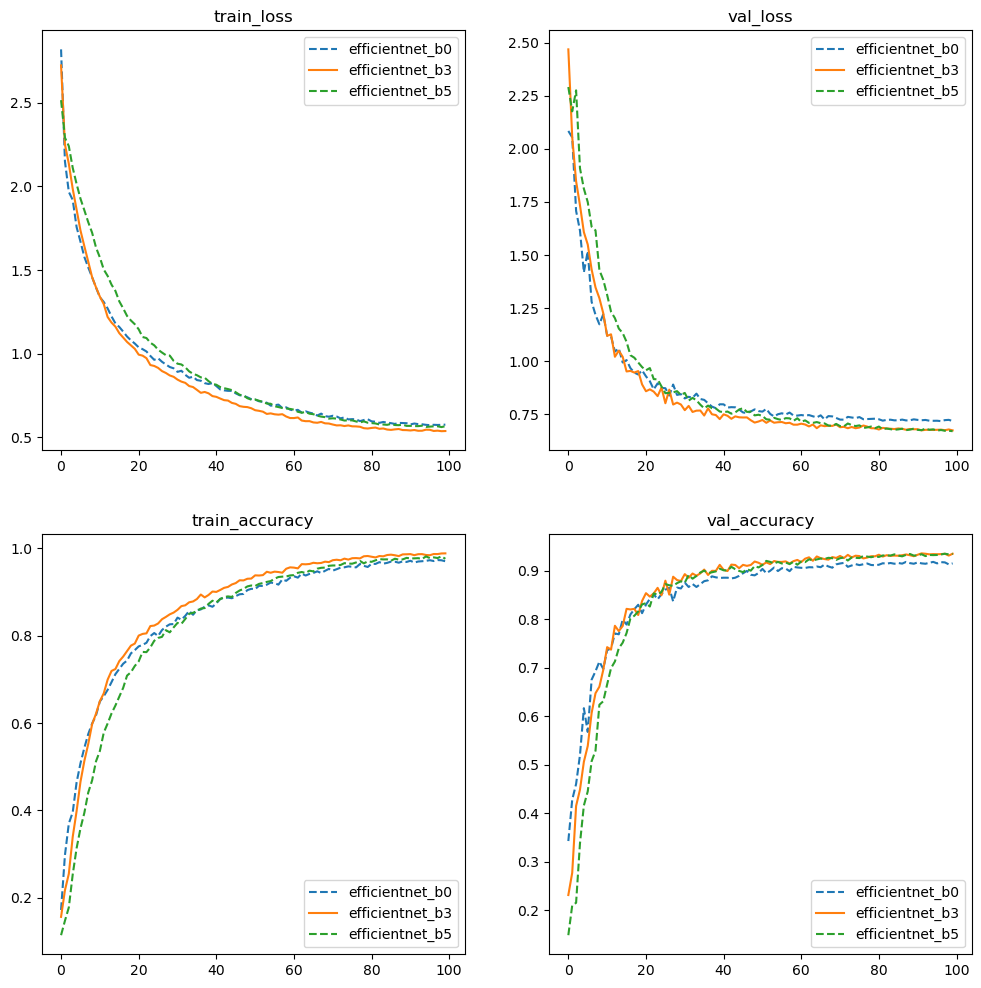

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = stats[net_names[0]].keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(stats[net_names[0]][field], label=net_names[0], linestyle="--")
    plt.plot(stats[net_names[1]][field], label=net_names[1])
    plt.plot(stats[net_names[2]][field], label=net_names[2], linestyle="--")
    plt.legend()
    plt.title(field)